Computing exact optimal (brute force)...
Optimal cost: 1307.84 km

Classical baselines:
Random search: 1307.84 km (ratio 1.000)
Hill climbing: 1307.84 km (ratio 1.000)

Building QAOA-guided tour...
  QAOA (7 qubits, p=4)... .... done
  Final energy: 17913.44
  → Selected Basti (p = 0.015)
  QAOA (6 qubits, p=4)... .... done
  Final energy: 19607.46
  → Selected Gonda (p = 0.016)
  QAOA (5 qubits, p=4)... .... done
  Final energy: 7361.63
  → Selected Gorakhpur (p = 0.134)
  QAOA (4 qubits, p=4)... .... done
  Final energy: 7218.58
  → Selected Sitapur (p = 0.134)
  QAOA (3 qubits, p=4)... .... done
  Final energy: 1694.64
  → Selected Bijnor (p = 0.180)
  QAOA (2 qubits, p=4)... .... done
  Final energy: 1635.68
  → Selected Ayodhya (p = 0.189)
  QAOA (1 qubits, p=4)... .... done
  Final energy: 10.41
  → Selected Kanpur (p = 0.611)
Raw QAOA-guided cost: 1770.65 km
Lucknow → Basti → Gonda → Gorakhpur → Sitapur → Bijnor → Ayodhya → Kanpur → Lucknow

Applying 2-opt refinement...
Final re

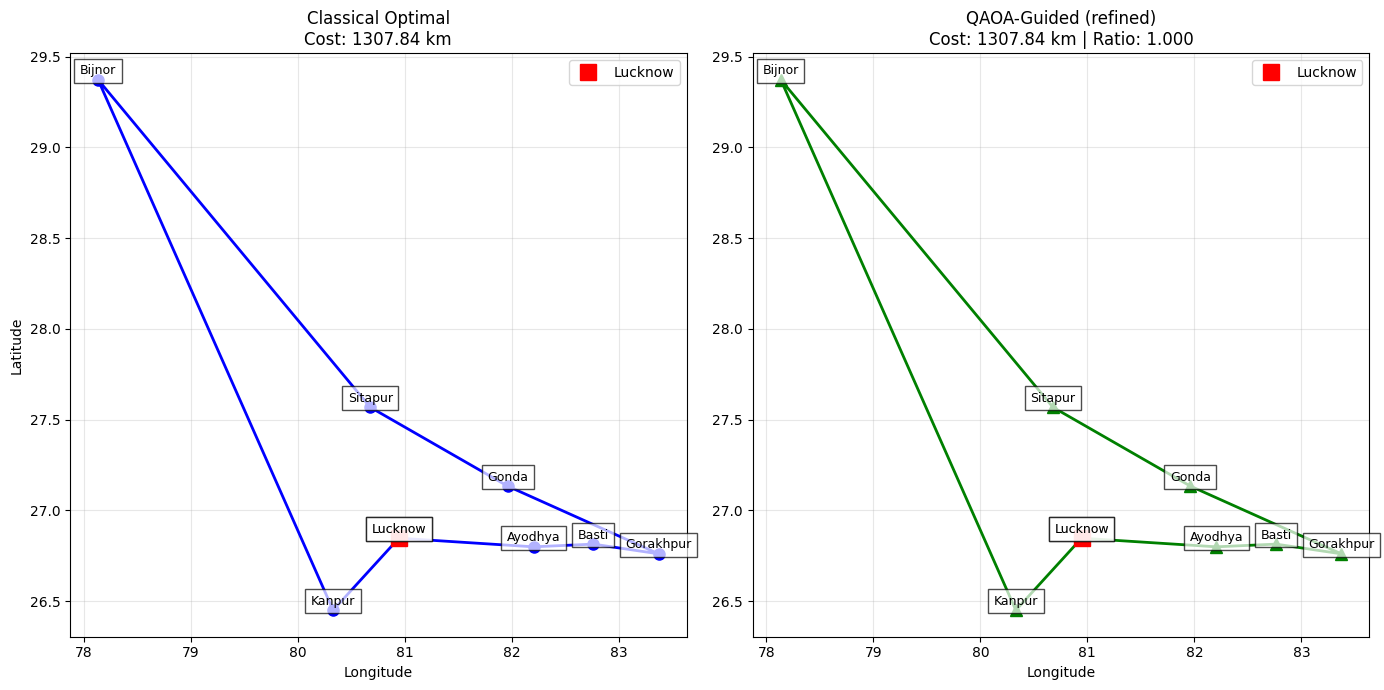

Plot saved: classical_vs_qaoa_comparison.png


In [3]:
"""
Hybrid QAOA-Guided Travelling Salesman Problem Solver
=====================================================

This script implements a hybrid quantum-classical approach to the Travelling Salesman Problem (TSP)
using the Quantum Approximate Optimization Algorithm (QAOA) for next-city selection in a greedy framework,
followed by classical 2-opt refinement. The problem instance uses real geographic coordinates of 8 cities
in Uttar Pradesh, India, with distances computed via the Haversine formula.

Author: Aditya Singh
Institution: Amity University Uttar Pradesh, Lucknow Campus
Date: 2026
License: MIT (or specify your preferred academic/open-source license)

Dependencies:
    - pennylane (>=0.35 recommended)
    - numpy
    - matplotlib
"""

import math
import random
import numpy as np
from itertools import permutations
from math import radians, sin, cos, sqrt, atan2
import pennylane as qml
from pennylane import numpy as pnp
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt


# ============================================================================
# 1. DATASET: Cities and Distance Matrix
# ============================================================================
CITIES = {
    "Lucknow": (26.8467, 80.9462),
    "Bijnor": (29.3732, 78.1351),
    "Kanpur": (26.4499, 80.3319),
    "Basti": (26.8140, 82.7630),
    "Ayodhya": (26.7991, 82.2047),
    "Gorakhpur": (26.76060, 83.3732),
    "Gonda": (27.1339, 81.9620),
    "Sitapur": (27.5680, 80.6790)
}

CITY_LIST = ["Lucknow"] + [c for c in CITIES if c != "Lucknow"]
N_CITIES = len(CITY_LIST)


def haversine(c1: str, c2: str) -> float:
    """Compute great-circle distance between two cities in kilometers."""
    lat1, lon1 = CITIES[c1]
    lat2, lon2 = CITIES[c2]
    R = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c


# Precompute distance matrix
DIST_MATRIX = np.array([[haversine(CITY_LIST[i], CITY_LIST[j]) for j in range(N_CITIES)]
                        for i in range(N_CITIES)])


def route_cost(indices: list[int]) -> float:
    """Calculate total tour length for a given sequence of city indices (cycle)."""
    total = sum(DIST_MATRIX[indices[i], indices[i + 1]] for i in range(len(indices) - 1))
    total += DIST_MATRIX[indices[-1], indices[0]]  # Return to start
    return total


# ============================================================================
# 2. CLASSICAL BASELINES
# ============================================================================
def compute_optimal_brute_force() -> tuple[list[str], float]:
    """Brute-force exact solution (feasible for 8 cities)."""
    best_cost = float('inf')
    best_route = None
    for perm in permutations(range(1, N_CITIES)):
        route = [0] + list(perm)
        cost = route_cost(route)
        if cost < best_cost:
            best_cost = cost
            best_route = route
    names = [CITY_LIST[i] for i in best_route] + [CITY_LIST[0]]
    return names, best_cost


def random_search(n_trials: int = 10000) -> tuple[list[str], float]:
    """Random permutation search as a weak baseline."""
    best_cost = float('inf')
    best_route = None
    for _ in range(n_trials):
        route = [0] + random.sample(range(1, N_CITIES), N_CITIES - 1)
        cost = route_cost(route)
        if cost < best_cost:
            best_cost = cost
            best_route = route
    names = [CITY_LIST[i] for i in best_route] + [CITY_LIST[0]]
    return names, best_cost


def hill_climbing(n_iter: int = 10000) -> tuple[list[str], float]:
    """Simple hill-climbing local search."""
    current = [0] + random.sample(range(1, N_CITIES), N_CITIES - 1)
    current_cost = route_cost(current)
    best, best_cost = current.copy(), current_cost

    for _ in range(n_iter):
        i, j = random.sample(range(1, N_CITIES), 2)
        neighbor = current.copy()
        neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        neigh_cost = route_cost(neighbor)
        if neigh_cost < current_cost:
            current = neighbor
            current_cost = neigh_cost
            if current_cost < best_cost:
                best = current.copy()
                best_cost = current_cost
    names = [CITY_LIST[i] for i in best] + [CITY_LIST[0]]
    return names, best_cost


# ============================================================================
# 3. QUANTUM COMPONENTS (QAOA for Next-City Selection)
# ============================================================================
def build_hamiltonian(current: int, remaining: set[int]) -> qml.Hamiltonian | None:
    """Construct QAOA cost Hamiltonian for next-city selection."""
    num_qubits = len(remaining)
    if num_qubits == 0:
        return None

    rem_list = list(remaining)
    max_dist = max(DIST_MATRIX[current, idx] for idx in rem_list)
    penalty = max_dist * 5.0  # Tuned penalty strength

    coeffs, ops = [], []

    # Cost: prefer shorter distances
    for i, idx in enumerate(rem_list):
        dist = DIST_MATRIX[current, idx]
        coeffs.extend([dist / 2, -dist / 2])
        ops.extend([qml.Identity(i), qml.PauliZ(i)])

    # Exactly-one constraint (quadratic penalty)
    coeffs.append(penalty * (num_qubits - 1)**2 / 4)
    ops.append(qml.Identity(0))
    for i in range(num_qubits):
        coeffs.append(-penalty * (num_qubits - 2) / 2)
        ops.append(qml.PauliZ(i))
    for i in range(num_qubits):
        for j in range(i + 1, num_qubits):
            coeffs.append(penalty / 2)
            ops.append(qml.PauliZ(i) @ qml.PauliZ(j))

    return qml.Hamiltonian(coeffs, ops)


def run_qaoa_next_city(current: int, remaining: set[int],
                       p_layers: int = 4, n_steps: int = 120) -> int:
    """Run QAOA to select next city; fallback to closest if convergence poor."""
    num_qubits = len(remaining)
    if num_qubits == 0:
        return None

    H = build_hamiltonian(current, remaining)
    if H is None:
        return list(remaining)[0]

    dev = qml.device("default.qubit", wires=num_qubits)

    @qml.qnode(dev)
    def cost_circuit(params):
        gammas, betas = params[:p_layers], params[p_layers:]
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)
        for layer in range(p_layers):
            qml.ApproxTimeEvolution(H, gammas[layer], 1)
            for wire in range(num_qubits):
                qml.RX(2 * betas[layer], wires=wire)
        return qml.expval(H)

    @qml.qnode(dev)
    def prob_circuit(params):
        gammas, betas = params[:p_layers], params[p_layers:]
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)
        for layer in range(p_layers):
            qml.ApproxTimeEvolution(H, gammas[layer], 1)
            for wire in range(num_qubits):
                qml.RX(2 * betas[layer], wires=wire)
        return qml.probs(wires=range(num_qubits))

    optimizer = AdamOptimizer(stepsize=0.08)
    params = pnp.random.uniform(0, np.pi, 2 * p_layers, requires_grad=True)

    print(f"  QAOA ({num_qubits} qubits, p={p_layers})... ", end="")
    for step in range(n_steps):
        params = optimizer.step(cost_circuit, params)
        if step % 30 == 0:
            print(".", end="", flush=True)
    print(" done")

    final_energy = float(cost_circuit(params))
    print(f"  Final energy: {final_energy:.2f}")

    probs = prob_circuit(params)

    best_prob, best_idx = 0, None
    for state in range(2**num_qubits):
        bitstring = format(state, f'0{num_qubits}b')
        if bitstring.count('1') == 1:
            pos = bitstring.index('1')
            city_idx = list(remaining)[pos]
            if probs[state] > best_prob:
                best_prob = probs[state]
                best_idx = city_idx

    if best_idx is None or best_prob < 0.01:
        print("  → Low confidence → fallback to closest city")
        dists = [DIST_MATRIX[current, idx] for idx in remaining]
        return list(remaining)[np.argmin(dists)]

    print(f"  → Selected {CITY_LIST[best_idx]} (p = {best_prob:.3f})")
    return best_idx


# ============================================================================
# 4. MAIN HYBRID ALGORITHM: QAOA-GREEDY + 2-OPT
# ============================================================================
def build_qaoa_guided_tour() -> tuple[list[str], float]:
    """Construct tour using iterative QAOA for next-city selection."""
    unvisited = set(range(1, N_CITIES))
    tour = [0]  # Start at Lucknow
    total = 0.0

    while unvisited:
        next_city = run_qaoa_next_city(tour[-1], unvisited)
        tour.append(next_city)
        unvisited.remove(next_city)
        total += DIST_MATRIX[tour[-2], next_city]

    total += DIST_MATRIX[tour[-1], 0]  # Return to start
    tour.append(0)
    names = [CITY_LIST[i] for i in tour]
    return names, total


def two_opt_refinement(indices: list[int]) -> list[int]:
    """Apply 2-opt local search to improve tour."""
    best = indices.copy()
    improved = True
    while improved:
        improved = False
        for i in range(1, len(best) - 2):
            for j in range(i + 1, len(best) - 1):
                candidate = best[:i] + best[i:j+1][::-1] + best[j+1:]
                if route_cost(candidate) < route_cost(best):
                    best = candidate
                    improved = True
                    break
            if improved:
                break
    return best


# ============================================================================
# 5. EXECUTION & RESULTS
# ============================================================================
if __name__ == "__main__":
    print("Computing exact optimal (brute force)...")
    optimal_names, optimal_cost = compute_optimal_brute_force()
    print(f"Optimal cost: {optimal_cost:.2f} km")

    # Classical baselines
    print("\nClassical baselines:")
    rand_names, rand_cost = random_search()
    print(f"Random search: {rand_cost:.2f} km (ratio {rand_cost/optimal_cost:.3f})")

    hc_names, hc_cost = hill_climbing()
    print(f"Hill climbing: {hc_cost:.2f} km (ratio {hc_cost/optimal_cost:.3f})")

    # Quantum-hybrid tour
    print("\nBuilding QAOA-guided tour...")
    raw_names, raw_cost = build_qaoa_guided_tour()
    print(f"Raw QAOA-guided cost: {raw_cost:.2f} km")
    print(" → ".join(raw_names))

    # Refine with 2-opt
    print("\nApplying 2-opt refinement...")
    refined_indices = two_opt_refinement([CITY_LIST.index(c) for c in raw_names[:-1]])
    refined_indices.append(0)  # close loop
    refined_names = [CITY_LIST[i] for i in refined_indices]
    refined_cost = route_cost(refined_indices)
    print(f"Final refined cost: {refined_cost:.2f} km")
    print(" → ".join(refined_names))

    ratio = refined_cost / optimal_cost
    print(f"Approximation ratio vs. optimal: {ratio:.3f}")

    # ============================================================================
    # 6. VISUALIZATION
    # ============================================================================
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

    # Classical optimal
    opt_lats = [CITIES[c][0] for c in optimal_names]
    opt_lons = [CITIES[c][1] for c in optimal_names]
    ax1.plot(opt_lons, opt_lats, 'b-o', lw=2, ms=8)
    ax1.plot(opt_lons[0], opt_lats[0], 'rs', ms=12, label='Lucknow')
    for i, c in enumerate(optimal_names):
        ax1.text(opt_lons[i], opt_lats[i] + 0.03, c, ha='center', fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.7))
    ax1.set_title(f"Classical Optimal\nCost: {optimal_cost:.2f} km")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # QAOA-guided refined
    ref_lats = [CITIES[c][0] for c in refined_names]
    ref_lons = [CITIES[c][1] for c in refined_names]
    ax2.plot(ref_lons, ref_lats, 'g-^', lw=2, ms=8)
    ax2.plot(ref_lons[0], ref_lats[0], 'rs', ms=12, label='Lucknow')
    for i, c in enumerate(refined_names):
        ax2.text(ref_lons[i], ref_lats[i] + 0.03, c, ha='center', fontsize=9,
                 bbox=dict(facecolor='white', alpha=0.7))
    ax2.set_title(f"QAOA-Guided (refined)\nCost: {refined_cost:.2f} km | Ratio: {ratio:.3f}")
    ax2.set_xlabel("Longitude")
    ax2.grid(True, alpha=0.3)
    ax2.legend()

    plt.tight_layout()
    plt.savefig("classical_vs_qaoa_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("Plot saved: classical_vs_qaoa_comparison.png")